# Download the Dataset

In [1]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
!tar -xzvf facades.tar.gz

--2019-05-30 15:00:45--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  16.7MB/s    in 1.7s    

2019-05-30 15:00:48 (16.7 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facade

# Imports


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import argparse
import os
import json
import glob
import random
import collections
import math
import time
import matplotlib.pyplot as plt 
from IPython.display import Image 
import matplotlib.pyplot as plt 
import cv2

# Show Some Images 

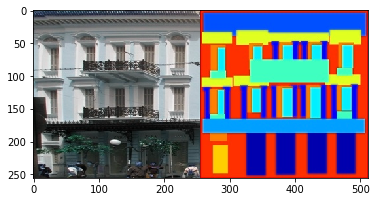

In [3]:
train_directory = 'facades/train/'
images = os.listdir(train_directory)
sample = np.random.choice(images)

image = cv2.imread(train_directory+sample)
plt.imshow(image)

# Default Parameters

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--input_dir", default= train_directory, help="path to folder containing images")
parser.add_argument("--mode", default = 'train', choices=["train", "test", "export"])
parser.add_argument("--output_dir", default = 'facades', help="where to put output files")
parser.add_argument("--seed", type=int)
parser.add_argument("--checkpoint", default= None, help="directory with checkpoint to resume training from or use for testing")

parser.add_argument("--max_steps", type=int, default = None, help="number of training steps (0 to disable)")
parser.add_argument("--max_epochs", type=int, default = 2000, help="number of training epochs")
parser.add_argument("--summary_freq", type=int, default=0, help="update summaries every summary_freq steps")
parser.add_argument("--progress_freq", type=int, default=500, help="display progress every progress_freq steps")
parser.add_argument("--trace_freq", type=int, default=0, help="trace execution every trace_freq steps")
parser.add_argument("--display_freq", type=int, default=500, help="write current training images every display_freq steps")
parser.add_argument("--save_freq", type=int, default=5000, help="save model every save_freq steps, 0 to disable")

parser.add_argument("--separable_conv", default = False, action="store_true", help="use separable convolutions in the generator")
parser.add_argument("--aspect_ratio", type=float, default=1.0, help="aspect ratio of output images (width/height)")
parser.add_argument("--batch_size", type=int, default=4, help="number of images in batch")
parser.add_argument("--which_direction", type=str, default="BtoA", choices=["AtoB", "BtoA"])
parser.add_argument("--ngf", type=int, default=32, help="number of generator filters in first conv layer")
parser.add_argument("--ndf", type=int, default=32, help="number of discriminator filters in first conv layer")
parser.add_argument("--scale_size", type=int, default=286, help="scale images to this size before cropping to 256x256")
parser.add_argument("--flip", dest="flip", action="store_true", help="flip images horizontally")
parser.add_argument("--no_flip", dest="flip", action="store_false", help="don't flip images horizontally")
parser.set_defaults(flip=True)
parser.add_argument("--lr", type=float, default=0.0002, help="initial learning rate for adam")
parser.add_argument("--beta1", type=float, default=0.5, help="momentum term of adam")
parser.add_argument("--l1_weight", type=float, default=50.0, help="weight on L1 term for generator gradient")
parser.add_argument("--gan_weight", type=float, default=1.0, help="weight on GAN term for generator gradient")

# export options
parser.add_argument("--output_filetype", default="png", choices=["png", "jpeg"])
a = parser.parse_args('')



EPS = 1e-12
CROP_SIZE = 256

Examples = collections.namedtuple("Examples", "paths, inputs, targets, count, steps_per_epoch")
Model = collections.namedtuple("Model", "outputs, predict_real, predict_fake, discrim_loss, discrim_grads_and_vars, gen_loss_GAN, gen_loss_L1, gen_grads_and_vars, train")

# Loading the images

In [ ]:
def load_examples():
    if a.input_dir is None or not os.path.exists(a.input_dir):
        raise Exception("input_dir does not exist")

    input_paths = glob.glob(os.path.join(a.input_dir, "*.jpg"))
    decode = tf.image.decode_jpeg
    if len(input_paths) == 0:
        input_paths = glob.glob(os.path.join(a.input_dir, "*.png"))
        decode = tf.image.decode_png

    if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

    def get_name(path):
        name, _ = os.path.splitext(os.path.basename(path))
        return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
    if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
    else:
        input_paths = sorted(input_paths)

    with tf.name_scope("load_images"):
        path_queue = tf.train.string_input_producer(input_paths, shuffle=a.mode == "train")
        reader = tf.WholeFileReader()
        paths, contents = reader.read(path_queue)
        raw_input = decode(contents)
        raw_input = tf.image.convert_image_dtype(raw_input, dtype=tf.float32)

        assertion = tf.assert_equal(tf.shape(raw_input)[2], 3, message="image does not have 3 channels")
        with tf.control_dependencies([assertion]):
            raw_input = tf.identity(raw_input)

        raw_input.set_shape([None, None, 3])

        # break apart image pair and move to range [-1, 1]
        width = tf.shape(raw_input)[1] # [height, width, channels]
        a_images = preprocess(raw_input[:,:width//2,:])
        b_images = preprocess(raw_input[:,width//2:,:])

    if a.which_direction == "AtoB":
        inputs, targets = [a_images, b_images]
    elif a.which_direction == "BtoA":
        inputs, targets = [b_images, a_images]
    else:
        raise Exception("invalid direction")

    # synchronize seed for image operations so that we do the same operations to both
    # input and output images
    seed = random.randint(0, 2**31 - 1)
    def transform(image, scale):
        r = image
        if a.flip:
            r = tf.image.random_flip_left_right(r, seed=seed)

        # area produces a nice downscaling, but does nearest neighbor for upscaling
        # assume we're going to be doing downscaling here
        
        r = tf.image.resize_images(r, [scale[0], scale[0]], method=tf.image.ResizeMethod.AREA)

        offset = tf.cast(tf.floor(tf.random_uniform([2], 0, tf.cast(scale[0], dtype=tf.float32) - CROP_SIZE + 1, seed=seed)), dtype=tf.int32)
        if a.scale_size > CROP_SIZE:
            r = tf.image.crop_to_bounding_box(r, offset[0], offset[1], CROP_SIZE, CROP_SIZE)
        elif a.scale_size < CROP_SIZE:
            raise Exception("scale size cannot be less than crop size")
        return r
    
    scale = tf.random_uniform([1], minval=286, maxval=300, dtype=tf.int32)
    with tf.name_scope("input_images"):
        input_images = transform(inputs, scale)

    with tf.name_scope("target_images"):
        target_images = transform(targets, scale)

    paths_batch, inputs_batch, targets_batch = tf.train.batch([paths, input_images, target_images], batch_size=a.batch_size)
    steps_per_epoch = int(math.ceil(len(input_paths) / a.batch_size))

    return Examples(
        paths=paths_batch,
        inputs=inputs_batch,
        targets=targets_batch,
        count=len(input_paths),
        steps_per_epoch=steps_per_epoch,
    )

# Helper Functions

In [ ]:
def preprocess(image):
    with tf.name_scope("preprocess"):
        # [0, 1] => [-1, 1]
        return image * 2 - 1


def deprocess(image):
    with tf.name_scope("deprocess"):
        # [-1, 1] => [0, 1]
        return (image + 1) / 2

def discrim_conv(batch_input, out_channels, stride):
    padded_input = tf.pad(batch_input, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT")
    return tf.layers.conv2d(padded_input, out_channels, kernel_size=4, strides=(stride, stride), padding="valid", kernel_initializer=tf.random_normal_initializer(0, 0.02))


def gen_conv(batch_input, out_channels):
    # [batch, in_height, in_width, in_channels] => [batch, out_height, out_width, out_channels]
    initializer = tf.random_normal_initializer(0, 0.02)
    if a.separable_conv:
        return tf.layers.separable_conv2d(batch_input, out_channels, kernel_size=4, strides=(2, 2), padding="same", depthwise_initializer=initializer, pointwise_initializer=initializer)
    else:
        return tf.layers.conv2d(batch_input, out_channels, kernel_size=4, strides=(2, 2), padding="same", kernel_initializer=initializer)


def gen_deconv(batch_input, out_channels):
    # [batch, in_height, in_width, in_channels] => [batch, out_height, out_width, out_channels]
    initializer = tf.random_normal_initializer(0, 0.02)
    if a.separable_conv:
        _b, h, w, _c = batch_input.shape
        resized_input = tf.image.resize_images(batch_input, [h * 2, w * 2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return tf.layers.separable_conv2d(resized_input, out_channels, kernel_size=4, strides=(1, 1), padding="same", depthwise_initializer=initializer, pointwise_initializer=initializer)
    else:
        return tf.layers.conv2d_transpose(batch_input, out_channels, kernel_size=4, strides=(2, 2), padding="same", kernel_initializer=initializer)


def lrelu(x, a):
    with tf.name_scope("lrelu"):
        # adding these together creates the leak part and linear part
        # then cancels them out by subtracting/adding an absolute value term
        # leak: a*x/2 - a*abs(x)/2
        # linear: x/2 + abs(x)/2

        # this block looks like it has 2 inputs on the graph unless we do this
        x = tf.identity(x)
        return (0.5 * (1 + a)) * x + (0.5 * (1 - a)) * tf.abs(x)

def batchnorm(inputs):
    return tf.layers.batch_normalization(inputs, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))


# Generator Network 

In [ ]:
def create_generator(generator_inputs, generator_outputs_channels):
    layers = []

    # encoder_1: [batch, 256, 256, in_channels] => [batch, 128, 128, ngf]
    with tf.variable_scope("encoder_1"):
        output = gen_conv(generator_inputs, a.ngf)
        layers.append(output)

    layer_specs = [
        a.ngf * 2, # encoder_2: [batch, 128, 128, ngf] => [batch, 64, 64, ngf * 2]
        a.ngf * 4, # encoder_3: [batch, 64, 64, ngf * 2] => [batch, 32, 32, ngf * 4]
        a.ngf * 8, # encoder_4: [batch, 32, 32, ngf * 4] => [batch, 16, 16, ngf * 8]
        a.ngf * 8, # encoder_5: [batch, 16, 16, ngf * 8] => [batch, 8, 8, ngf * 8]
        a.ngf * 8, # encoder_6: [batch, 8, 8, ngf * 8] => [batch, 4, 4, ngf * 8]
        a.ngf * 8, # encoder_7: [batch, 4, 4, ngf * 8] => [batch, 2, 2, ngf * 8]
        a.ngf * 8, # encoder_8: [batch, 2, 2, ngf * 8] => [batch, 1, 1, ngf * 8]
    ]

    for out_channels in layer_specs:
        with tf.variable_scope("encoder_%d" % (len(layers) + 1)):
            rectified = lrelu(layers[-1], 0.2)
            # [batch, in_height, in_width, in_channels] => [batch, in_height/2, in_width/2, out_channels]
            convolved = gen_conv(rectified, out_channels)
            output = batchnorm(convolved)
            layers.append(output)

    layer_specs = [
        (a.ngf * 8, 0.5),   # decoder_8: [batch, 1, 1, ngf * 8] => [batch, 2, 2, ngf * 8 * 2]
        (a.ngf * 8, 0.5),   # decoder_7: [batch, 2, 2, ngf * 8 * 2] => [batch, 4, 4, ngf * 8 * 2]
        (a.ngf * 8, 0.5),   # decoder_6: [batch, 4, 4, ngf * 8 * 2] => [batch, 8, 8, ngf * 8 * 2]
        (a.ngf * 8, 0.0),   # decoder_5: [batch, 8, 8, ngf * 8 * 2] => [batch, 16, 16, ngf * 8 * 2]
        (a.ngf * 4, 0.0),   # decoder_4: [batch, 16, 16, ngf * 8 * 2] => [batch, 32, 32, ngf * 4 * 2]
        (a.ngf * 2, 0.0),   # decoder_3: [batch, 32, 32, ngf * 4 * 2] => [batch, 64, 64, ngf * 2 * 2]
        (a.ngf, 0.0),       # decoder_2: [batch, 64, 64, ngf * 2 * 2] => [batch, 128, 128, ngf * 2]
    ]

    num_encoder_layers = len(layers)
    for decoder_layer, (out_channels, dropout) in enumerate(layer_specs):
        skip_layer = num_encoder_layers - decoder_layer - 1
        with tf.variable_scope("decoder_%d" % (skip_layer + 1)):
            if decoder_layer == 0:
                # first decoder layer doesn't have skip connections
                # since it is directly connected to the skip_layer
                input = layers[-1]
            else:
                input = tf.concat([layers[-1], layers[skip_layer]], axis=3)

            rectified = tf.nn.relu(input)
            # [batch, in_height, in_width, in_channels] => [batch, in_height*2, in_width*2, out_channels]
            output = gen_deconv(rectified, out_channels)
            output = batchnorm(output)

            if dropout > 0.0:
                output = tf.nn.dropout(output, keep_prob=1 - dropout)

            layers.append(output)

    # decoder_1: [batch, 128, 128, ngf * 2] => [batch, 256, 256, generator_outputs_channels]
    with tf.variable_scope("decoder_1"):
        input = tf.concat([layers[-1], layers[0]], axis=3)
        rectified = tf.nn.relu(input)
        output = gen_deconv(rectified, generator_outputs_channels)
        output = tf.tanh(output)
        layers.append(output)

    return layers[-1]


# Discriminator Network

In [ ]:
def create_discriminator(discrim_inputs, discrim_targets):
        n_layers = 3
        layers = []

        # 2x [batch, height, width, in_channels] => [batch, height, width, in_channels * 2]
        input = tf.concat([discrim_inputs, discrim_targets], axis=3)

        # layer_1: [batch, 256, 256, in_channels * 2] => [batch, 128, 128, ndf]
        with tf.variable_scope("layer_1"):
            convolved = discrim_conv(input, a.ndf, stride=2)
            rectified = lrelu(convolved, 0.2)
            layers.append(rectified)

        # layer_2: [batch, 128, 128, ndf] => [batch, 64, 64, ndf * 2]
        # layer_3: [batch, 64, 64, ndf * 2] => [batch, 32, 32, ndf * 4]
        # layer_4: [batch, 32, 32, ndf * 4] => [batch, 31, 31, ndf * 8]
        for i in range(n_layers):
            with tf.variable_scope("layer_%d" % (len(layers) + 1)):
                out_channels = a.ndf * min(2**(i+1), 8)
                stride = 1 if i == n_layers - 1 else 2  # last layer here has stride 1
                convolved = discrim_conv(layers[-1], out_channels, stride=stride)
                normalized = batchnorm(convolved)
                rectified = lrelu(normalized, 0.2)
                layers.append(rectified)

        # layer_5: [batch, 31, 31, ndf * 8] => [batch, 30, 30, 1]
        with tf.variable_scope("layer_%d" % (len(layers) + 1)):
            convolved = discrim_conv(rectified, out_channels=1, stride=1)
            output = tf.sigmoid(convolved)
            layers.append(output)

        return layers[-1]

# Intitialize the Model

In [ ]:
def create_model(inputs, targets):
    with tf.variable_scope("generator"):
        out_channels = int(targets.get_shape()[-1])
        outputs = create_generator(inputs, out_channels)

    # create two copies of discriminator, one for real pairs and one for fake pairs
    # they share the same underlying variables
    with tf.name_scope("real_discriminator"):
        with tf.variable_scope("discriminator"):
            # 2x [batch, height, width, channels] => [batch, 30, 30, 1]
            predict_real = create_discriminator(inputs, targets)

    with tf.name_scope("fake_discriminator"):
        with tf.variable_scope("discriminator", reuse=True):
            # 2x [batch, height, width, channels] => [batch, 30, 30, 1]
            predict_fake = create_discriminator(inputs, outputs)

    with tf.name_scope("discriminator_loss"):
        # minimizing -tf.log will try to get inputs to 1
        # predict_real => 1
        # predict_fake => 0
        discrim_loss = tf.reduce_mean(-(tf.log(predict_real + EPS) + tf.log(1 - predict_fake + EPS)))

    with tf.name_scope("generator_loss"):
        # predict_fake => 1
        # abs(targets - outputs) => 0
        gen_loss_GAN = tf.reduce_mean(-tf.log(predict_fake + EPS))
        gen_loss_L1 = tf.reduce_mean(tf.abs(targets - outputs))
        gen_loss = gen_loss_GAN * a.gan_weight + gen_loss_L1 * a.l1_weight

    with tf.name_scope("discriminator_train"):
        discrim_tvars = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
        discrim_optim = tf.train.AdamOptimizer(a.lr, a.beta1)
        discrim_grads_and_vars = discrim_optim.compute_gradients(discrim_loss, var_list=discrim_tvars)
        discrim_train = discrim_optim.apply_gradients(discrim_grads_and_vars)

    with tf.name_scope("generator_train"):
        with tf.control_dependencies([discrim_train]):
            gen_tvars = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
            gen_optim = tf.train.AdamOptimizer(a.lr, a.beta1)
            gen_grads_and_vars = gen_optim.compute_gradients(gen_loss, var_list=gen_tvars)
            gen_train = gen_optim.apply_gradients(gen_grads_and_vars)

    ema = tf.train.ExponentialMovingAverage(decay=0.99)
    update_losses = ema.apply([discrim_loss, gen_loss_GAN, gen_loss_L1])

    global_step = tf.train.get_or_create_global_step()
    incr_global_step = tf.assign(global_step, global_step+1)

    return Model(
        predict_real=predict_real,
        predict_fake=predict_fake,
        discrim_loss=ema.average(discrim_loss),
        discrim_grads_and_vars=discrim_grads_and_vars,
        gen_loss_GAN=ema.average(gen_loss_GAN),
        gen_loss_L1=ema.average(gen_loss_L1),
        gen_grads_and_vars=gen_grads_and_vars,
        outputs=outputs,
        train=tf.group(update_losses, incr_global_step, gen_train),
    )

# Save and Display Inputs and Outputs

In [ ]:
def save_images(fetches, step=None):
    image_dir = os.path.join(a.output_dir, "images")
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    filesets = []
    for i, in_path in enumerate(fetches["paths"][0:1]):
        name, _ = os.path.splitext(os.path.basename(in_path.decode("utf8")))
        fileset = {"name": name, "step": step}
        for kind in ["inputs", "outputs", "targets"]:
            print(kind)
            filename = name + "-" + kind + ".png"
            if step is not None:
                filename = "%08d-%s" % (step, filename)
            fileset[kind] = filename
            out_path = os.path.join(image_dir, filename)
            
            contents = fetches[kind][i]
            
            with open(out_path, "wb") as f:
                f.write(contents)
            img = cv2.imread(out_path)
            plt.imshow(img[:,:,::-1])
            plt.show()
        filesets.append(fileset)
    return filesets


def append_index(filesets, step=False):
    index_path = os.path.join(a.output_dir, "index.html")
    if os.path.exists(index_path):
        index = open(index_path, "a")
    else:
        index = open(index_path, "w")
        index.write("<html><body><table><tr>")
        if step:
            index.write("<th>step</th>")
        index.write("<th>name</th><th>input</th><th>output</th><th>target</th></tr>")

    for fileset in filesets:
        index.write("<tr>")

        if step:
            index.write("<td>%d</td>" % fileset["step"])
        index.write("<td>%s</td>" % fileset["name"])

        for kind in ["inputs", "outputs", "targets"]:
            index.write("<td><img src='images/%s'></td>" % fileset[kind])

        index.write("</tr>")
    return index_path

# Main 

In [ ]:
def main():
    if a.seed is None:
        a.seed = random.randint(0, 2**31 - 1)

    tf.set_random_seed(a.seed)
    np.random.seed(a.seed)
    random.seed(a.seed)

    if not os.path.exists(a.output_dir):
        os.makedirs(a.output_dir)

    if a.mode == "test" or a.mode == "export":
        if a.checkpoint is None:
            raise Exception("checkpoint required for test mode")

        # load some options from the checkpoint
        options = {"which_direction", "ngf", "ndf"}
        with open(os.path.join(a.checkpoint, "options.json")) as f:
            for key, val in json.loads(f.read()).items():
                if key in options:
                    print("loaded", key, "=", val)
                    setattr(a, key, val)
        # disable these features in test mode
        a.scale_size = CROP_SIZE
        a.flip = False

    for k, v in a._get_kwargs():
        print(k, "=", v)

    with open(os.path.join(a.output_dir, "options.json"), "w") as f:
        f.write(json.dumps(vars(a), sort_keys=True, indent=4))

    if a.mode == "export":

        input = tf.placeholder(tf.float32, shape=[CROP_SIZE, CROP_SIZE, 3])
        batch_input = tf.expand_dims(input, axis=0)

        with tf.variable_scope("generator"):
            output = deprocess(create_generator(preprocess(batch_input), 3))

        key = tf.placeholder(tf.string, shape=[1])
        inputs = {
            "key": key.name,
            "input": input.name
        }
        tf.add_to_collection("inputs", json.dumps(inputs))
        outputs = {
            "key":  tf.identity(key).name,
            "output": output.name,
        }
        tf.add_to_collection("outputs", json.dumps(outputs))

        init_op = tf.global_variables_initializer()
        restore_saver = tf.train.Saver()
        export_saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(init_op)
            print("loading model from checkpoint")
            checkpoint = tf.train.latest_checkpoint(a.checkpoint)
            restore_saver.restore(sess, checkpoint)
            print("exporting model")
            export_saver.export_meta_graph(filename=os.path.join(a.output_dir, "export.meta"))
            export_saver.save(sess, os.path.join(a.output_dir, "export"), write_meta_graph=False)

        return

    examples = load_examples()
    print("examples count = %d" % examples.count)

    # inputs and targets are [batch_size, height, width, channels]
    model = create_model(examples.inputs, examples.targets)

    inputs = deprocess(examples.inputs)
    targets = deprocess(examples.targets)
    outputs = deprocess(model.outputs)

    def convert(image):
        if a.aspect_ratio != 1.0:
            # upscale to correct aspect ratio
            size = [CROP_SIZE, int(round(CROP_SIZE * a.aspect_ratio))]
            image = tf.image.resize_images(image, size=size, method=tf.image.ResizeMethod.BICUBIC)

        return tf.image.convert_image_dtype(image, dtype=tf.uint8, saturate=True)

    # reverse any processing on images so they can be written to disk or displayed to user
    with tf.name_scope("convert_inputs"):
        converted_inputs = convert(inputs)

    with tf.name_scope("convert_targets"):
        converted_targets = convert(targets)

    with tf.name_scope("convert_outputs"):
        converted_outputs = convert(outputs)

    with tf.name_scope("encode_images"):
        display_fetches = {
            "paths": examples.paths,
            "inputs": tf.map_fn(tf.image.encode_png, converted_inputs, dtype=tf.string, name="input_pngs"),
            "targets": tf.map_fn(tf.image.encode_png, converted_targets, dtype=tf.string, name="target_pngs"),
            "outputs": tf.map_fn(tf.image.encode_png, converted_outputs, dtype=tf.string, name="output_pngs"),
        }

    # summaries
    with tf.name_scope("inputs_summary"):
        tf.summary.image("inputs", converted_inputs)

    with tf.name_scope("targets_summary"):
        tf.summary.image("targets", converted_targets)

    with tf.name_scope("outputs_summary"):
        tf.summary.image("outputs", converted_outputs)

    with tf.name_scope("predict_real_summary"):
        tf.summary.image("predict_real", tf.image.convert_image_dtype(model.predict_real, dtype=tf.uint8))

    with tf.name_scope("predict_fake_summary"):
        tf.summary.image("predict_fake", tf.image.convert_image_dtype(model.predict_fake, dtype=tf.uint8))

    tf.summary.scalar("discriminator_loss", model.discrim_loss)
    tf.summary.scalar("generator_loss_GAN", model.gen_loss_GAN)
    tf.summary.scalar("generator_loss_L1", model.gen_loss_L1)

    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name + "/values", var)

    for grad, var in model.discrim_grads_and_vars + model.gen_grads_and_vars:
        tf.summary.histogram(var.op.name + "/gradients", grad)

    with tf.name_scope("parameter_count"):
        parameter_count = tf.reduce_sum([tf.reduce_prod(tf.shape(v)) for v in tf.trainable_variables()])

    saver = tf.train.Saver(max_to_keep=1)

    logdir = a.output_dir if (a.trace_freq > 0 or a.summary_freq > 0) else None
    sv = tf.train.Supervisor(logdir=logdir, save_summaries_secs=0, saver=None)
    with sv.managed_session() as sess:
        print("parameter_count =", sess.run(parameter_count))

        if a.checkpoint is not None:
            print("loading model from checkpoint")
            checkpoint = tf.train.latest_checkpoint(a.checkpoint)
            saver.restore(sess, checkpoint)

        max_steps = 2**32
        if a.max_epochs is not None:
            max_steps = examples.steps_per_epoch * a.max_epochs
        if a.max_steps is not None:
            max_steps = a.max_steps

        if a.mode == "test":
            # lab_colorizationtesting
            # at most, process the test data once
            start = time.time()
            max_steps = min(examples.steps_per_epoch, max_steps)
            for step in range(max_steps):
                results = sess.run(display_fetches)
                filesets = save_images(results)
                for i, f in enumerate(filesets):
                    print("evaluated image", f["name"])
                index_path = append_index(filesets)
            print("wrote index at", index_path)
            print("rate", (time.time() - start) / max_steps)
        else:
            # training
            start = time.time()

            for step in range(max_steps):
                def should(freq):
                    return freq > 0 and ((step + 1) % freq == 0 or step == max_steps - 1)

                options = None
                run_metadata = None
                if should(a.trace_freq):
                    options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()

                fetches = {
                    "train": model.train,
                    "global_step": sv.global_step,
                }

                if should(a.progress_freq):
                    fetches["discrim_loss"] = model.discrim_loss
                    fetches["gen_loss_GAN"] = model.gen_loss_GAN
                    fetches["gen_loss_L1"] = model.gen_loss_L1

                if should(a.summary_freq):
                    fetches["summary"] = sv.summary_op

                if should(a.display_freq):
                    fetches["display"] = display_fetches

                results = sess.run(fetches, options=options, run_metadata=run_metadata)

                if should(a.summary_freq):
                    print("recording summary")
                    sv.summary_writer.add_summary(results["summary"], results["global_step"])

                if should(a.display_freq):
                    print("Display saved images")
                    filesets = save_images(results["display"], step=results["global_step"])
                    append_index(filesets, step=True)

                if should(a.trace_freq):
                    print("recording trace")
                    sv.summary_writer.add_run_metadata(run_metadata, "step_%d" % results["global_step"])

                if should(a.progress_freq):
                    # global_step will have the correct step count if we resume from a checkpoint
                    train_epoch = math.ceil(results["global_step"] / examples.steps_per_epoch)
                    train_step = (results["global_step"] - 1) % examples.steps_per_epoch + 1
                    rate = (step + 1) * a.batch_size / (time.time() - start)
                    remaining = (max_steps - step) * a.batch_size / rate
                    print("progress  epoch %d  step %d  image/sec %0.1f  remaining %dm" % (train_epoch, train_step, rate, remaining / 60))
                    print("discrim_loss", results["discrim_loss"])
                    print("gen_loss_GAN", results["gen_loss_GAN"])
                    print("gen_loss_L1", results["gen_loss_L1"])

                if should(a.save_freq):
                    print("saving model")
                    saver.save(sess, os.path.join(a.output_dir, "model"), global_step=sv.global_step)

                if sv.should_stop():
                    break



aspect_ratio = 1.0
batch_size = 4
beta1 = 0.5
checkpoint = None
display_freq = 500
flip = True
gan_weight = 1.0
input_dir = facades/train/
l1_weight = 50.0
lr = 0.0002
max_epochs = 2000
max_steps = None
mode = train
ndf = 32
ngf = 32
output_dir = facades
output_filetype = png
progress_freq = 500
save_freq = 5000
scale_size = 286
seed = 1562301930
separable_conv = False
summary_freq = 0
trace_freq = 0
which_direction = BtoA
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input p

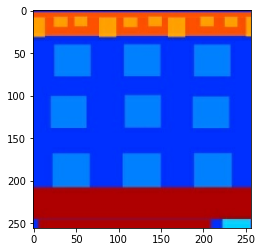

outputs


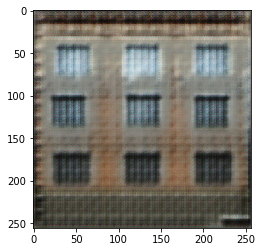

targets


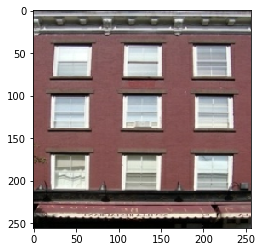

progress  epoch 5  step 99  image/sec 18.7  remaining 709m
discrim_loss 0.7900391
gen_loss_GAN 1.4967577
gen_loss_L1 0.35021022
Display saved images
inputs


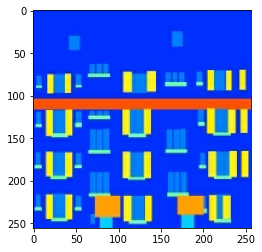

outputs


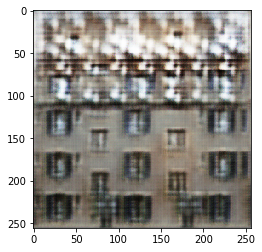

targets


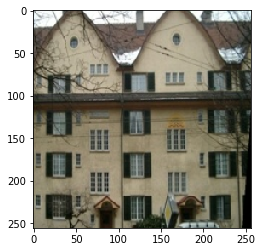

progress  epoch 10  step 99  image/sec 27.9  remaining 475m
discrim_loss 0.8270468
gen_loss_GAN 1.4666114
gen_loss_L1 0.35803202


In [ ]:
main()